# Stage 1: PI-HLNN **without** FP_AMPL Conditioning — LOS / NLOS Classification
## Ablation: Same DualCircuit Architecture, Zero-Initialised Hidden States

**Purpose**: Ablation study — identical architecture to `stage1_pi_hlnn.ipynb` but **without FP_AMPL1/2/3** conditioning. This isolates the contribution of the FP features vs. pure CIR-driven ODE dynamics.

| | PI-HLNN + FP (original) | PI-HLNN No FP (this notebook) | LSTM | BERT |
|---|---|---|---|---|
| Input | CIR (60×1) + FP_AMPL1/2/3 | CIR only (60×1) | CIR only (60×1) | CIR only (60×1) |
| h₀ init | FP → Linear → tanh × 0.1 | torch.zeros | torch.zeros | Learnable CLS token |
| Pooling | Average (time-averaged ODE trajectory) | Average (time-averaged ODE trajectory) | Last hidden | CLS token |
| Architecture | DualCircuit LTC ODE | DualCircuit LTC ODE | Standard LSTM | Transformer Encoder |
| Params | ~17.2k | ~16.9k (−FP layers, −attention) | ~19.3k | ~73.3k |

**What changes**: `fp_to_los_init`, `fp_to_nlos_init`, and attention pooling layers are removed. Both circuits always start from `h₀ = zeros(32)`. Pooling uses time-averaged ODE trajectory (matching the original). Everything else (ODE cells, cross-circuit gating, classifier, training config) is identical.

In [1]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 32,        # per circuit; total embedding = 64 (2 × 32)
    "input_size": 1,
    "dropout": 0.2,
    "ode_unfolds": 6,
    "batch_size": 64,
    "max_epochs": 40,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "warmup_epochs": 3,
    "patience": 10,
    "grad_clip": 1.0,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "seed": 42,
}

In [2]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


---
## Section 2: Data Loading, ROI Alignment & 70/15/15 Split

Identical CIR preprocessing to the original PI-HLNN — same data, same split, same seed.
**No FP_AMPL features** — CIR only (same as LSTM/BERT for fair comparison).

In [3]:
# ==========================================
# SMART ROI ALIGNMENT (identical to original)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# ==========================================
# DATASET LOADER (CIR only — NO FP_AMPL)
# ==========================================
def load_cir_dataset(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Returns: X (N, 60, 1), y (N,) — no FP features."""
    PRE = CONFIG["pre_crop"]
    TOTAL = CONFIG["total_len"]
    processed_seqs, labels = [], []

    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    print(f"  Samples: {len(df)}, CIR columns: {len(cir_cols)}")

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        leading_edge = get_roi_alignment(sig)
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min, local_max = np.min(crop), np.max(crop)
        rng = local_max - local_min
        crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)

        processed_seqs.append(crop)
        labels.append(float(row['Label']))

    X = np.array(processed_seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    print(f"  Output shape: X={X.shape}, y={y.shape}")
    print(f"  LOS: {int(np.sum(y == 0))}, NLOS: {int(np.sum(y == 1))}")
    return X, y


# Load and split 70/15/15 (same seed & stratification as original)
X_all, y_all = load_cir_dataset("../dataset/channels/combined_uwb_dataset.csv")

indices = np.arange(len(y_all))
idx_train, idx_temp = train_test_split(
    indices, test_size=CONFIG["val_ratio"] + CONFIG["test_ratio"],
    stratify=y_all, random_state=CONFIG["seed"]
)
idx_val, idx_test = train_test_split(
    idx_temp, test_size=CONFIG["test_ratio"] / (CONFIG["val_ratio"] + CONFIG["test_ratio"]),
    stratify=y_all[idx_temp], random_state=CONFIG["seed"]
)

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_val,   y_val   = X_all[idx_val],   y_all[idx_val]
X_test,  y_test  = X_all[idx_test],  y_all[idx_test]

print(f"\nSplit (70/15/15):")
print(f"  Train: {X_train.shape[0]} (LOS: {int(np.sum(y_train==0))}, NLOS: {int(np.sum(y_train==1))})")
print(f"  Val:   {X_val.shape[0]} (LOS: {int(np.sum(y_val==0))}, NLOS: {int(np.sum(y_val==1))})")
print(f"  Test:  {X_test.shape[0]} (LOS: {int(np.sum(y_test==0))}, NLOS: {int(np.sum(y_test==1))})")

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Samples: 3600, CIR columns: 1016
  Output shape: X=(3600, 60, 1), y=(3600,)
  LOS: 1800, NLOS: 1800

Split (70/15/15):
  Train: 2520 (LOS: 1260, NLOS: 1260)
  Val:   540 (LOS: 270, NLOS: 270)
  Test:  540 (LOS: 270, NLOS: 270)


---
## Section 3: Model Architecture — DualCircuit PI-HLNN (No FP Conditioning)

Identical ODE cells and cross-circuit gating as the original.
**Differences**: `fp_to_los_init` and `fp_to_nlos_init` removed — both circuits start from `h₀ = zeros(32)`.
Average pooling matches the original (time-averaged ODE trajectory, no attention).

```
h_los₀  = zeros(32)   ← was: 0.1 * tanh(Linear(FP_AMPL))
h_nlos₀ = zeros(32)   ← was: 0.1 * tanh(Linear(FP_AMPL))
pooling  = mean(dim=1) ← same as original (no attention)
```

In [4]:
class PILiquidCell(nn.Module):
    """
    Conductance-based LTC cell (Hasani et al. 2020).
    Identical to the original — no changes.
    """
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size  = input_size
        self.ode_unfolds = ode_unfolds

        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        cm_t = cm / (dt / self.ode_unfolds)
        v    = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num  = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den  = w_gate.sum(dim=1)
            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator
            v = torch.clamp(v, -1.0, 1.0)

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau


class DualCircuit_PI_HLNN_NoFP(nn.Module):
    """
    Dual-circuit PI-HLNN WITHOUT FP_AMPL conditioning.
    Both circuits always start from h₀ = zeros(32).
    Uses average pooling (matching the original PI-HLNN).
    """
    def __init__(self, input_size=1, hidden_size=32, dropout=0.2, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size

        # Two specialised circuits (identical to original)
        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)

        # NO fp_to_los_init / fp_to_nlos_init — always zero-init

        # Cross-circuit projection matrices (identical to original)
        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)

        # Gated cross-circuit mixing (identical to original)
        self.gate_los  = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos = nn.Linear(hidden_size * 2, hidden_size)

        # Classifier (identical to original)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def _run_circuits(self, x_seq):
        batch_size, seq_len, _ = x_seq.size()

        # Zero-initialised hidden states (no FP conditioning)
        h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)

        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]

            proj_nlos_to_los = self.P_nlos2los(h_nlos)
            proj_los_to_nlos = self.P_los2nlos(h_los)

            g_los  = torch.sigmoid(self.gate_los( torch.cat([h_los,  proj_nlos_to_los], dim=1)))
            g_nlos = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, proj_los_to_nlos], dim=1)))

            h_los_in  = h_los  + g_los  * proj_nlos_to_los
            h_nlos_in = h_nlos + g_nlos * proj_los_to_nlos

            h_los,  tau_los  = self.cell_los( x_t, h_los_in)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos_in)

            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))

        los_all  = torch.cat(los_states,  dim=1)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list,  dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)
        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, los_all, nlos_all):
        """Time-average the ODE trajectory from each circuit — no attention pooling.
           Computes (1/T) Σ h(t), a standard dynamical-systems observable that
           summarises the continuous-time hidden-state evolution."""
        h_los_avg  = los_all.mean(dim=1)   # (batch, hidden)
        h_nlos_avg = nlos_all.mean(dim=1)  # (batch, hidden)
        return torch.cat([h_los_avg, h_nlos_avg], dim=1)   # (batch, 2*hidden)

    def forward(self, x_seq, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq)
        h_fused = self._pool_and_fuse(los_all, nlos_all)
        pred = self.classifier(h_fused)
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq):
        """Return 64-dim fused embedding for Stage 2/3."""
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq)
        return self._pool_and_fuse(los_all, nlos_all)


# Parameter count
_m = DualCircuit_PI_HLNN_NoFP(input_size=1, hidden_size=32)
_total = sum(p.numel() for p in _m.parameters())
print(f"DualCircuit_PI_HLNN_NoFP parameter count: {_total:,}")
print(f"  cell_los + cell_nlos:  {sum(p.numel() for p in _m.cell_los.parameters()) * 2:,}")
print(f"  FP conditioning:       NONE (zero-init h₀)")
print(f"  Projection matrices:   {sum(p.numel() for p in [*_m.P_nlos2los.parameters(), *_m.P_los2nlos.parameters()]):,}")
print(f"  Gates:                 {sum(p.numel() for p in [*_m.gate_los.parameters(), *_m.gate_nlos.parameters()]):,}")
print(f"  Classifier:            {sum(p.numel() for p in _m.classifier.parameters()):,}")
print(f"  Pooling:               average-over-time (no attention — time-averaged ODE trajectory)")
print(f"  Embedding dim: {_m.hidden_size * 2} (2 x {_m.hidden_size})")
print(f"  ODE hidden state: clamped to [-1, 1] each sub-step")
del _m

DualCircuit_PI_HLNN_NoFP parameter count: 16,897
  cell_los + cell_nlos:  8,576
  FP conditioning:       NONE (zero-init h₀)
  Projection matrices:   2,048
  Gates:                 4,160
  Classifier:            2,113
  Pooling:               average-over-time (no attention — time-averaged ODE trajectory)
  Embedding dim: 64 (2 x 32)
  ODE hidden state: clamped to [-1, 1] each sub-step


---
## Section 4: Training Pipeline

Same training config as the original PI-HLNN: AdamW, cosine LR with warmup, early stopping.
**No FP tensors** — model receives only CIR sequences.

In [5]:
# ==========================================
# TRAINING PIPELINE (No FP conditioning)
# ==========================================
def train_model(X_train, y_train, X_val, y_val, config=CONFIG):
    print(f"Training on {len(X_train)} samples, validating on {len(X_val)}")
    print(f"  FP_AMPL conditioning: DISABLED (zero-init h₀)")

    X_tr = torch.tensor(X_train).to(device)
    y_tr = torch.tensor(y_train).unsqueeze(1).to(device)
    X_va = torch.tensor(X_val).to(device)
    y_va = torch.tensor(y_val).unsqueeze(1).to(device)

    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

    model = DualCircuit_PI_HLNN_NoFP(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        dropout=config["dropout"],
        ode_unfolds=config.get("ode_unfolds", 6)
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"],
                            weight_decay=config["weight_decay"])

    warmup_epochs = config["warmup_epochs"]
    total_epochs  = config["max_epochs"]

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return max(0.01, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
    best_val_acc     = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["max_epochs"]):
        model.train()
        train_loss_sum = 0
        train_correct, train_total = 0, 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred, tau_los, tau_nlos = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
            optimizer.step()
            train_loss_sum += loss.item() * len(batch_x)
            train_correct  += ((pred > 0.5).float() == batch_y).sum().item()
            train_total    += len(batch_x)

        train_loss = train_loss_sum / train_total
        train_acc  = train_correct / train_total

        model.eval()
        with torch.no_grad():
            val_pred, val_tau_los, val_tau_nlos = model(X_va)
            val_loss = criterion(val_pred, y_va)
            val_acc  = ((val_pred > 0.5).float() == y_va).float().mean().item()

        lr_now = optimizer.param_groups[0]['lr']
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(lr_now)

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc     = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0 or epoch == config["max_epochs"] - 1:
            print(f"  Ep {epoch:>3} | Loss: {train_loss:.4f} | Val Acc: {100*val_acc:.2f}% | Best: {100*best_val_acc:.2f}% | LR: {lr_now:.1e}")

        if patience_counter >= config["patience"]:
            print(f"  Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)
    print(f"\nBest Validation Accuracy: {100*best_val_acc:.2f}%")
    return model, (X_va, y_va), history


best_model, best_data, best_history = train_model(X_train, y_train, X_val, y_val)

Training on 2520 samples, validating on 540
  FP_AMPL conditioning: DISABLED (zero-init h₀)
  Ep   0 | Loss: 0.6935 | Val Acc: 50.00% | Best: 50.00% | LR: 3.3e-04
  Ep   5 | Loss: 0.5697 | Val Acc: 71.67% | Best: 71.85% | LR: 9.9e-04
  Ep  10 | Loss: 0.4185 | Val Acc: 86.85% | Best: 86.85% | LR: 9.1e-04
  Ep  15 | Loss: 0.1852 | Val Acc: 91.85% | Best: 91.85% | LR: 7.6e-04
  Ep  20 | Loss: 0.1074 | Val Acc: 95.00% | Best: 96.30% | LR: 5.6e-04
  Ep  25 | Loss: 0.0873 | Val Acc: 94.63% | Best: 96.30% | LR: 3.5e-04
  Ep  30 | Loss: 0.0744 | Val Acc: 97.78% | Best: 97.78% | LR: 1.7e-04
  Ep  35 | Loss: 0.0719 | Val Acc: 97.78% | Best: 97.78% | LR: 4.4e-05
  Ep  39 | Loss: 0.0707 | Val Acc: 97.78% | Best: 97.78% | LR: 1.0e-05

Best Validation Accuracy: 97.78%


---
## Section 5: Diagnostics

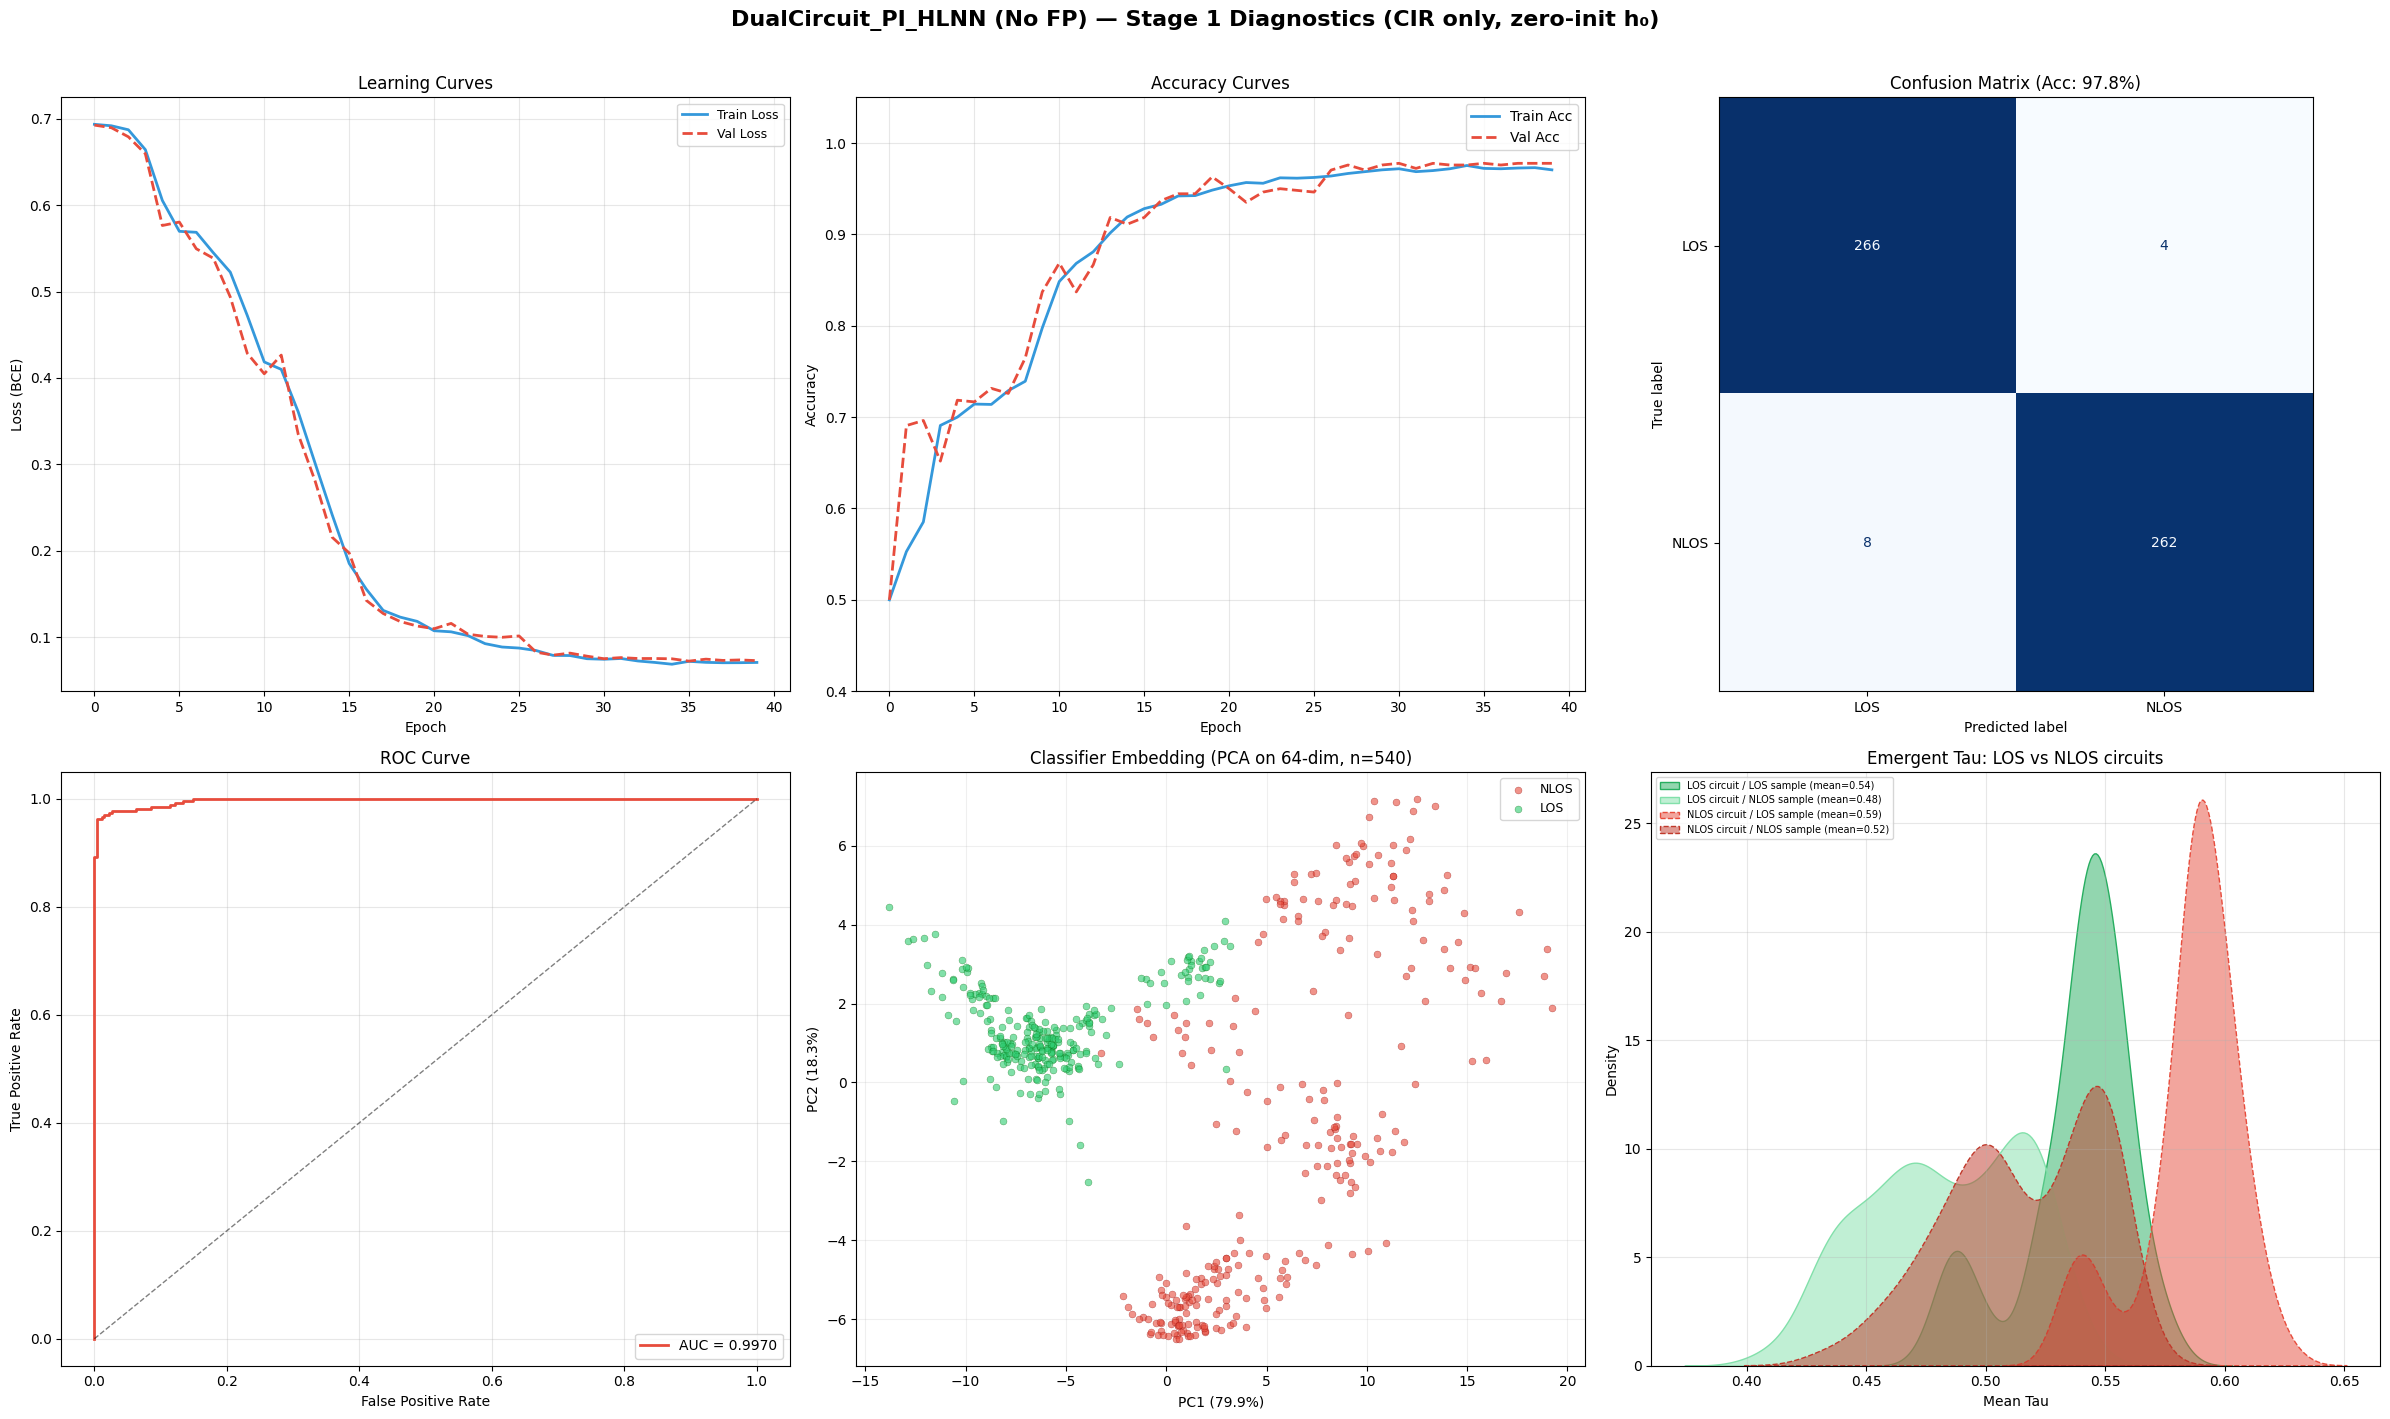

In [6]:
# ==========================================
# DIAGNOSTIC GRID (2x3) — DualCircuit PI-HLNN (No FP)
# ==========================================
def plot_diagnostics(model, val_data, history):
    X_va, y_va = val_data
    model.eval()

    with torch.no_grad():
        preds, los_hist, nlos_hist, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            model(X_va, return_dynamics=True)
        embeddings = model.embed(X_va).cpu().numpy()

    y_true = y_va.cpu().numpy().flatten()
    y_prob = preds.cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(float)

    tau_los_np  = tau_los_mean.cpu().numpy().mean(axis=1)
    tau_nlos_np = tau_nlos_mean.cpu().numpy().mean(axis=1)

    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)

    # --- 1. LEARNING CURVES ---
    ax = axs[0, 0]
    ax.plot(history["train_loss"], label='Train Loss', color='#3498db', lw=2)
    ax.plot(history["val_loss"],   label='Val Loss',   color='#e74c3c', lw=2, ls='--')
    ax.set_title("Learning Curves")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (BCE)")
    ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

    # --- 2. ACCURACY CURVES ---
    ax = axs[0, 1]
    ax.plot(history["train_acc"], label='Train Acc', color='#3498db', lw=2)
    ax.plot(history["val_acc"],   label='Val Acc',   color='#e74c3c', lw=2, ls='--')
    ax.set_title("Accuracy Curves")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.set_ylim([0.4, 1.05]); ax.legend(); ax.grid(True, alpha=0.3)

    # --- 3. CONFUSION MATRIX ---
    ax = axs[0, 2]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    acc = (y_true == y_pred).mean()
    ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")

    # --- 4. ROC CURVE ---
    ax = axs[1, 0]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right'); ax.grid(True, alpha=0.3)

    # --- 5. EMBEDDING SCATTER (PCA on 64-dim fused embedding) ---
    ax = axs[1, 1]
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(embeddings)
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(emb_scaled)

    los_mask  = y_true == 0
    nlos_mask = y_true == 1
    ax.scatter(emb_pca[nlos_mask, 0], emb_pca[nlos_mask, 1],
               c='#e74c3c', s=25, alpha=0.6, edgecolors='darkred', linewidths=0.3, label='NLOS', zorder=4)
    ax.scatter(emb_pca[los_mask, 0], emb_pca[los_mask, 1],
               c='#2ecc71', s=25, alpha=0.6, edgecolors='darkgreen', linewidths=0.3, label='LOS', zorder=5)
    ax.legend(fontsize=9)
    ax.set_title(f"Classifier Embedding (PCA on 64-dim, n={len(y_true)})")
    ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
    ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
    ax.grid(True, alpha=0.2)

    # --- 6. TAU DISTRIBUTION — LOS vs NLOS circuits ---
    ax = axs[1, 2]
    sns.kdeplot(tau_los_np[y_true == 0],  ax=ax, fill=True, color='#27ae60',
                label=f'LOS circuit / LOS sample (mean={tau_los_np[y_true==0].mean():.2f})',   alpha=0.5)
    sns.kdeplot(tau_los_np[y_true == 1],  ax=ax, fill=True, color='#82e0aa',
                label=f'LOS circuit / NLOS sample (mean={tau_los_np[y_true==1].mean():.2f})', alpha=0.5)
    sns.kdeplot(tau_nlos_np[y_true == 0], ax=ax, fill=True, color='#e74c3c',
                label=f'NLOS circuit / LOS sample (mean={tau_nlos_np[y_true==0].mean():.2f})', alpha=0.5, ls='--')
    sns.kdeplot(tau_nlos_np[y_true == 1], ax=ax, fill=True, color='#c0392b',
                label=f'NLOS circuit / NLOS sample (mean={tau_nlos_np[y_true==1].mean():.2f})', alpha=0.5, ls='--')
    ax.set_title("Emergent Tau: LOS vs NLOS circuits")
    ax.set_xlabel("Mean Tau"); ax.legend(fontsize=7); ax.grid(True, alpha=0.3)

    plt.suptitle("DualCircuit_PI_HLNN (No FP) — Stage 1 Diagnostics (CIR only, zero-init h₀)",
                 fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_diagnostics(best_model, best_data, best_history)

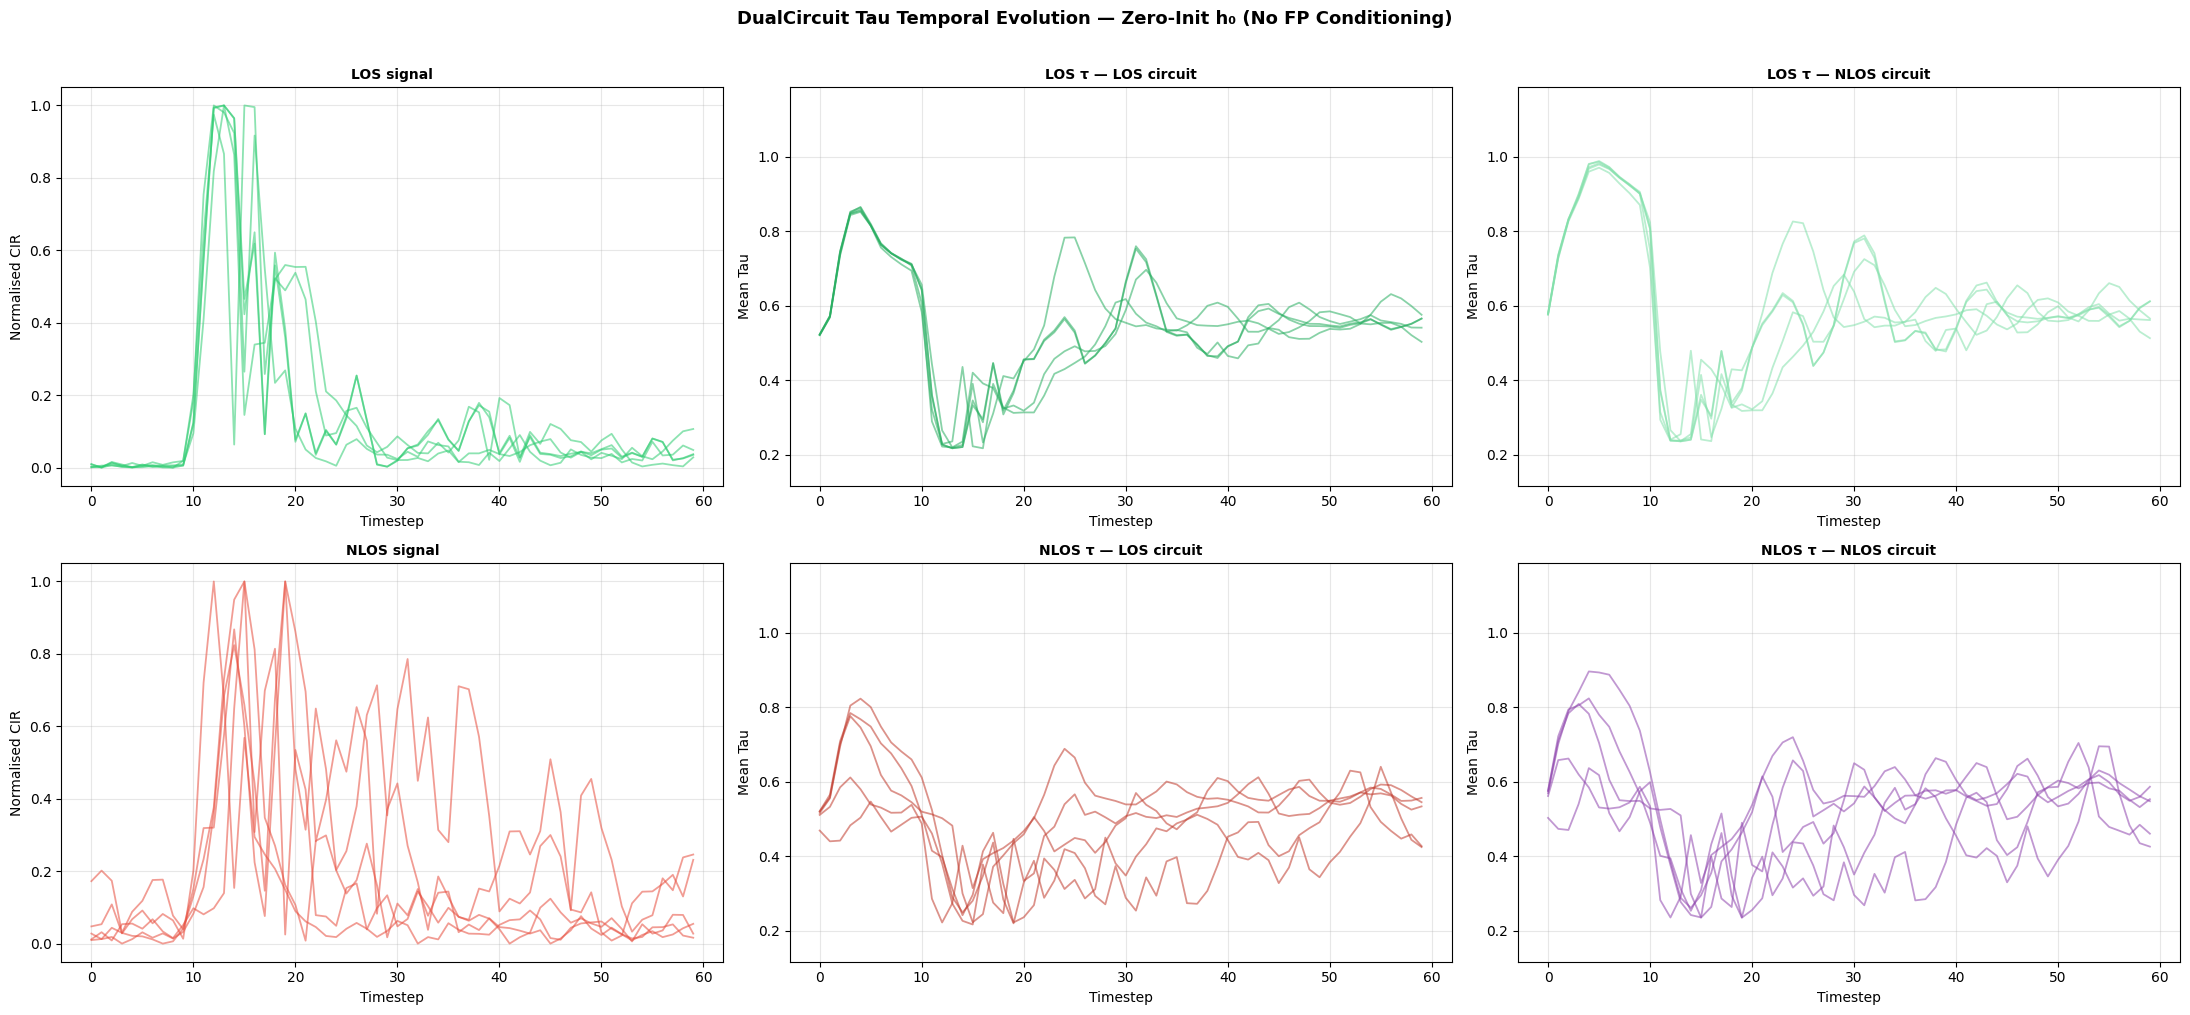

In [7]:
# ==========================================
# TAU TEMPORAL EVOLUTION — both circuits
# ==========================================
def plot_tau_temporal(model, val_data, n_samples=5):
    X_va, y_va = val_data
    model.eval()
    with torch.no_grad():
        _, _, _, tau_los_hist, tau_nlos_hist, _, _ = model(X_va, return_dynamics=True)

    y_true = y_va.cpu().numpy().flatten()
    tau_los_t  = tau_los_hist.cpu().numpy().mean(axis=2)
    tau_nlos_t = tau_nlos_hist.cpu().numpy().mean(axis=2)
    x_input    = X_va.cpu().numpy().squeeze(-1)

    los_idx  = np.where(y_true == 0)[0][:n_samples]
    nlos_idx = np.where(y_true == 1)[0][:n_samples]

    all_tau = np.concatenate([
        tau_los_t[los_idx].flatten(), tau_los_t[nlos_idx].flatten(),
        tau_nlos_t[los_idx].flatten(), tau_nlos_t[nlos_idx].flatten()
    ])
    tau_ymin = max(0, all_tau.min() - 0.1)
    tau_ymax = all_tau.max() * 1.2

    fig, axs = plt.subplots(2, 3, figsize=(22, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    titles = [
        ('LOS signal',           los_idx,  '#2ecc71', x_input),
        ('LOS \u03c4 — LOS circuit', los_idx,  '#27ae60', tau_los_t),
        ('LOS \u03c4 — NLOS circuit',los_idx,  '#82e0aa', tau_nlos_t),
        ('NLOS signal',          nlos_idx, '#e74c3c', x_input),
        ('NLOS \u03c4 — LOS circuit',nlos_idx, '#c0392b', tau_los_t),
        ('NLOS \u03c4 — NLOS circuit',nlos_idx,'#8e44ad', tau_nlos_t),
    ]

    for ax, (title, idx, color, data) in zip(axs.flat, titles):
        for i in idx:
            ax.plot(data[i], alpha=0.55, color=color, lw=1.3)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel("Timestep"); ax.grid(True, alpha=0.3)
        if 'signal' in title:
            ax.set_ylabel("Normalised CIR")
        else:
            ax.set_ylabel("Mean Tau")
            ax.set_ylim([tau_ymin, tau_ymax])

    plt.suptitle("DualCircuit Tau Temporal Evolution — Zero-Init h₀ (No FP Conditioning)",
                 fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_tau_temporal(best_model, best_data, n_samples=5)

---
## Section 6: Test Set Evaluation & Save Artifacts

Test Accuracy: 97.04%
Test AUC:      0.9944

Classification Report:
              precision    recall  f1-score   support

         LOS       0.96      0.99      0.97       270
        NLOS       0.98      0.96      0.97       270

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



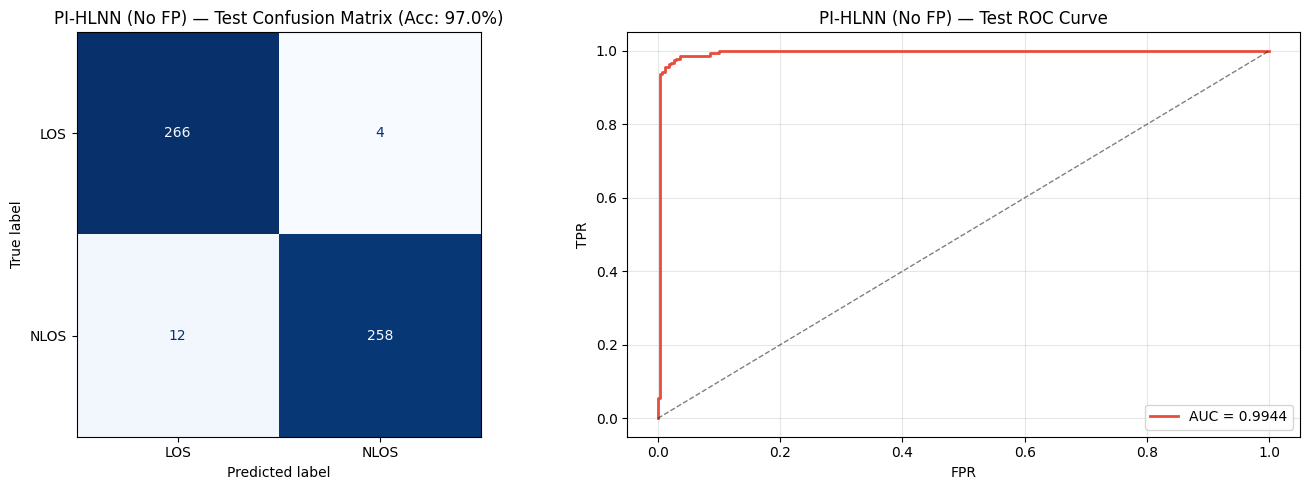


Model summary:
  Architecture: DualCircuit_PI_HLNN_NoFP (hidden=32 per circuit)
  FP conditioning: NONE (zero-init h₀)
  Embedding dim: 64 (2 × 32)
  Total params: 16,897


In [8]:
# ==========================================
# TEST SET EVALUATION (No FP)
# ==========================================
best_model.eval()
X_te = torch.tensor(X_test).to(device)
y_te = torch.tensor(y_test).unsqueeze(1).to(device)

with torch.no_grad():
    test_pred, _, _ = best_model(X_te)
    test_prob = test_pred.cpu().numpy().flatten()
    test_acc  = ((test_pred > 0.5).float() == y_te).float().mean().item()
    test_pred_np = (test_prob > 0.5).astype(float)
    test_true_np = y_test.flatten()

# ROC AUC
fpr, tpr, _ = roc_curve(test_true_np, test_prob)
test_auc = auc(fpr, tpr)

print(f"Test Accuracy: {100*test_acc:.2f}%")
print(f"Test AUC:      {test_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_np, test_pred_np, target_names=['LOS', 'NLOS']))

# Confusion matrix + ROC
cm = confusion_matrix(test_true_np, test_pred_np)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ax = axs[0]
disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f"PI-HLNN (No FP) — Test Confusion Matrix (Acc: {100*test_acc:.1f}%)")

ax = axs[1]
ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {test_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_title("PI-HLNN (No FP) — Test ROC Curve")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
ax.legend(loc='lower right'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel summary:")
print(f"  Architecture: DualCircuit_PI_HLNN_NoFP (hidden={best_model.hidden_size} per circuit)")
print(f"  FP conditioning: NONE (zero-init h₀)")
print(f"  Embedding dim: {best_model.hidden_size * 2} (2 × {best_model.hidden_size})")
print(f"  Total params: {sum(p.numel() for p in best_model.parameters()):,}")

In [9]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
torch.save(best_model.state_dict(), "stage1_pi_hlnn_no_fp_best.pt")
print("Saved: stage1_pi_hlnn_no_fp_best.pt")

torch.save({"config": CONFIG}, "stage1_pi_hlnn_no_fp_config.pt")
print("Saved: stage1_pi_hlnn_no_fp_config.pt")

print(f"\nArtifacts ready.")

Saved: stage1_pi_hlnn_no_fp_best.pt
Saved: stage1_pi_hlnn_no_fp_config.pt

Artifacts ready.


---
## Section 7: Summary — FP vs No-FP Comparison

After running both notebooks, compare:

| Metric | PI-HLNN + FP | PI-HLNN No FP (this) | Difference |
|--------|-------------|---------------------|------------|
| Val Accuracy | 100% | — | — |
| Test Accuracy | 100% | — | — |
| Convergence | ~10 epochs | — | — |
| Parameters | ~17.2k | ~17.0k | −256 (FP layers) |
| FP_AMPL input | Yes (3 features) | No | Ablated |

**Interpretation**:
- If No-FP matches the original → FP_AMPL doesn't help (CIR alone is sufficient)
- If No-FP is worse → FP_AMPL provides discriminative information that accelerates/improves learning
- Key to watch: convergence speed (epochs to best val acc) and final accuracy

In [10]:
print("Stage 1 PI-HLNN (No FP) ablation complete.")
print("Model artifact: stage1_pi_hlnn_no_fp_best.pt")
print("Config artifact: stage1_pi_hlnn_no_fp_config.pt")
print("\nCompare with:")
print("  PI-HLNN + FP:  capstone/lnn/stage1_pi_hlnn.ipynb")
print("  LSTM:          capstone/lstm/stage1_lstm.ipynb")
print("  BERT:          capstone/bert/stage1_bert.ipynb")

Stage 1 PI-HLNN (No FP) ablation complete.
Model artifact: stage1_pi_hlnn_no_fp_best.pt
Config artifact: stage1_pi_hlnn_no_fp_config.pt

Compare with:
  PI-HLNN + FP:  capstone/lnn/stage1_pi_hlnn.ipynb
  LSTM:          capstone/lstm/stage1_lstm.ipynb
  BERT:          capstone/bert/stage1_bert.ipynb
